# The Full Pipeline for Exploiting Loop-Like Exercices in The Classification of Parkinson's Disease

## Content

1. Data Preparation
    1. Data Collection
    2. Preprocessing
    3. Splitting
1. Exploratory Data Analysis
    1. Basic Statistical Measures
    2. Correlation
    3. Plotting
1. Data Manipulation
    1. Feature Extraction
    2. Interpolation
1. Model Architecture Design
1. Model Compilation
1. Model Training
1. Hyperparameter Tuning
1. Model Evaluation

## 1. Data Preparation

### A. Data Collection

<p>In this phase, the data is loaded from the files that were created by the data collection system.</p>
<p>This is done using packages and modules specifically designed for the hierarchical structure of this data.</p>
<p>The module responsible for data collection also performs some basic preprocessing tasks, such as removing invalid data that shouldn't exist (e.g. letters in numeric values).</p>
<p>The data concerning the cursive <em>"L"</em> task in the French language is loaded.</p>

In [1]:
from dataaccess.filedatareader import FileDataReader

reader = FileDataReader('../data/Patients Records 05_04_2019')
info, data = reader.load_french(tasks=[3])

Loading the data, please wait.
Data loaded successfully.


### B. Preprocessing

<p>In the preprocessing phase, the following steps are carried:</p>
<ol>
    <li>Handling missing data.</li>
    <li>Keeping only the data of healthy controls (HCs) and parkinson's disease patients (PDs).</li>
</ol>
<p>In our case, since there are no missing values in the data concerning Task 3 in French anyways, missing data is already handled.</p>
<p>Any exercice that doesn't correspond to an HC or a PD is removed (e.g. Alzheimers...).</p>

In [2]:
from datamanipulation.datageneration import get_pd_hc_only

info, data = get_pd_hc_only(info, data)

### C. Splitting

<p>In the splitting phase, I divide the dataset into training and test sets. The training set is used to train the model, and the test set (which is 30% of the data) evaluates the final model's performance, the test set is stratified to resemble the original data's label distrobution as much as possible.</p>
<p>Since the data size is limiting, no validation set was left out, instead, 3-fold cross validation is used later.</p>
<p>In the following phases, only the training data is used.</p>

In [3]:
from datamanipulation.datageneration import stratified_train_test_split

info_train, info_test, data_train, data_test = stratified_train_test_split(info, data, 'PD/HC')

## 2. Exploratory Data Analysis

### A. Basic Statistical Measures

<p>The first thing that can be noticed, is that the distrobution between HCs and PDs is very biased, which can create generalization problems, these problems can be observed in specificity and sensitivity.</p>

In [4]:
df = info_train.groupby('PD/HC').count()[["Age"]]
df.columns = ['Count']
df

,Count
PD/HC,
0,100
1,15


<p>Now let's compare some basic statistical measures between PDs and HCs.</p>
<p>Starting with PDs:</p>

In [5]:
hcs = data_train[data_train['PD/HC']==1]
hcs.describe()

,PD/HC,Time,X,Y,P,Az,Al,Task
count,36537.0,36537.000000,36537.000000,36537.000000,36537.00000,36537.000000,36537.000000,36537.0
mean,1.0,10925.115198,10268.176260,34983.039193,330.36448,1445.793305,521.731122,3.0
std,0.0,7487.616698,6171.477979,3965.842672,266.08722,368.802523,142.914394,0.0
min,1.0,0.000000,9.000000,25412.000000,0.00000,0.000000,220.000000,3.0
25%,1.0,4878.000000,4403.000000,31504.000000,0.00000,1280.000000,430.000000,3.0
50%,1.0,9901.000000,7859.000000,33065.000000,350.00000,1430.000000,510.000000,3.0
75%,1.0,15532.000000,16295.000000,39129.000000,559.00000,1610.000000,570.000000,3.0
max,1.0,31479.000000,22425.000000,40629.000000,1023.00000,3460.000000,900.000000,3.0


Then HCs:

In [6]:
pds = data_train[data_train['PD/HC']==0]
pds.describe()

,PD/HC,Time,X,Y,P,Az,Al,Task
count,152512.0,152512.000000,152512.000000,152512.000000,152512.000000,152512.000000,152512.000000,152512.0
mean,0.0,9014.172616,10882.636947,34565.529670,479.301524,1547.885609,536.751928,3.0
std,0.0,9878.625083,6507.945597,4384.802017,1373.765751,447.032386,132.333951,0.0
min,0.0,0.000000,9.000000,9157.000000,0.000000,0.000000,-900.000000,3.0
25%,0.0,3074.000000,4750.000000,31295.000000,0.000000,1300.000000,460.000000,3.0
50%,0.0,6139.000000,9675.000000,32401.000000,407.000000,1540.000000,520.000000,3.0
75%,0.0,10663.250000,16710.000000,39016.000000,612.000000,1750.000000,590.000000,3.0
max,0.0,58572.000000,51156.000000,40639.000000,23194.000000,3580.000000,900.000000,3.0


<ul>
    <li>Time: The most important distinction when it comes to time, is that the mean, first quartile, median, and third quartile, are all higher in PDs than in HCs, which indicates that generaly, PDs take more time to complete the exercices than HCs.</li>
    <li>Movement in X and Y: Slight disgraphia is also noticed in the X and Y axis for PDs, especially in the X axis.</li>
    <li>The pressure is also signicantly less in PDs than in HCs, with a huge difference in its standard deviation.</li>
    <li>When it comes to altitude, HCs seem to hold the pen a little bit straighter than PDs.</li>
</ul>

### B. Correlation

The correlation matrix for all participants:

In [7]:
data_train.corr(numeric_only=True)

,PD/HC,Time,X,Y,P,Az,Al,Task
PD/HC,1.000000,0.079480,-0.037623,0.038249,-0.047396,-0.092696,-0.044073,NaN
Time,0.079480,1.000000,0.203815,0.440181,-0.025178,0.014295,-0.214067,NaN
X,-0.037623,0.203815,1.000000,-0.053756,-0.010190,-0.064940,0.042583,NaN
Y,0.038249,0.440181,-0.053756,1.000000,0.021805,0.029710,-0.130257,NaN
P,-0.047396,-0.025178,-0.010190,0.021805,1.000000,0.048866,-0.005480,NaN
Az,-0.092696,0.014295,-0.064940,0.029710,0.048866,1.000000,0.026142,NaN
Al,-0.044073,-0.214067,0.042583,-0.130257,-0.005480,0.026142,1.000000,NaN
Task,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The correlation matrix for PDs:

In [8]:
pds.corr(numeric_only=True)

,PD/HC,Time,X,Y,P,Az,Al,Task
PD/HC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Time,NaN,1.000000,0.175211,0.397981,-0.022850,0.042117,-0.212914,NaN
X,NaN,0.175211,1.000000,-0.080979,-0.015306,-0.078657,0.061059,NaN
Y,NaN,0.397981,-0.080979,1.000000,0.025993,0.052420,-0.098575,NaN
P,NaN,-0.022850,-0.015306,0.025993,1.000000,0.049163,-0.000289,NaN
Az,NaN,0.042117,-0.078657,0.052420,0.049163,1.000000,0.005044,NaN
Al,NaN,-0.212914,0.061059,-0.098575,-0.000289,0.005044,1.000000,NaN
Task,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The correlation matrix for HCs:

In [9]:
hcs.corr(numeric_only=True)

,PD/HC,Time,X,Y,P,Az,Al,Task
PD/HC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Time,NaN,1.000000,0.400210,0.693595,-0.005355,-0.113560,-0.215059,NaN
X,NaN,0.400210,1.000000,0.086689,0.045959,-0.016592,-0.040511,NaN
Y,NaN,0.693595,0.086689,1.000000,-0.000007,-0.072722,-0.259562,NaN
P,NaN,-0.005355,0.045959,-0.000007,1.000000,-0.018884,-0.166203,NaN
Az,NaN,-0.113560,-0.016592,-0.072722,-0.018884,1.000000,0.103091,NaN
Al,NaN,-0.215059,-0.040511,-0.259562,-0.166203,0.103091,1.000000,NaN
Task,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


- There doesn't seem to be any strong correlation between any of the feature in PDs, HCs and both, except for the time's correlation with X and Y which is normal considering the direction of writing.
- There is however a big difference in the correlation between time and position, in between HCs and PDs; HCs have a higher correlation, which is due to their writing being faster, so it adapts better to the fast change in time.

### C. Plotting

First let's get 3 random HCs and 3 random PDs:

In [10]:
import numpy as np

def rand_imgs():
    rand_hcs = []
    rand_pds = []
    for i in range(3):
        rand_hcs.append(np.random.randint(0, len(hcs.index.unique())))
        rand_pds.append(np.random.randint(0, len(pds.index.unique())))
    hc_images = []
    pd_images = []
    for i, j in zip(rand_hcs, rand_pds):
        hc_images.append(hcs.loc[hcs.index.unique()[i]])
        pd_images.append(pds.loc[pds.index.unique()[j]])
    return hc_images, pd_images

rand_hcs, rand_pds = rand_imgs()

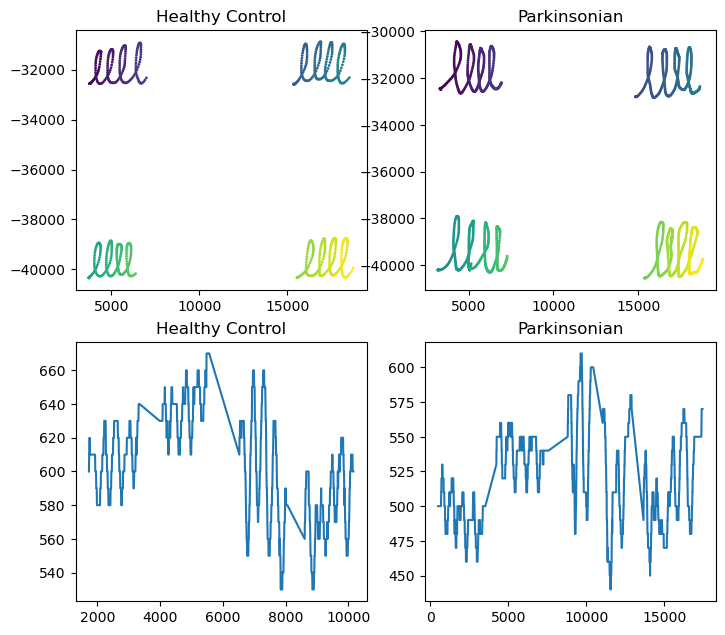

In [5]:
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf


hc_img = np.array(get_random_image(X, y, 0))
pd_img = np.array(get_random_image(X, y, 1))



plt.close()
plt.figure(1)

plt.subplot(2, 2, 1)
plt.subplots_adjust(right=4)
plt.title('Healthy Control')
plt.scatter(hc_img[:,1], hc_img[:,2] * -1, c=hc_img[:,0] + 1, s=1)

plt.subplot(2, 2, 2)
plt.subplots_adjust(left=4, right=5)
plt.title('Parkinsonian')
plt.scatter(pd_img[:,1], pd_img[:,2] * -1, c=pd_img[:,0] + 1, s=1)

i = 5

plt.subplot(2, 2, 3)
plt.subplots_adjust(right=6, top=1.3)
plt.title('Healthy Control')
plt.plot(hc_img[:,0], hc_img[:,i])

plt.subplot(2, 2, 4)
plt.subplots_adjust(left=4, right=5, top=1.3)
plt.title('Parkinsonian')
plt.plot(pd_img[:,0], pd_img[:,i])
plt.show()

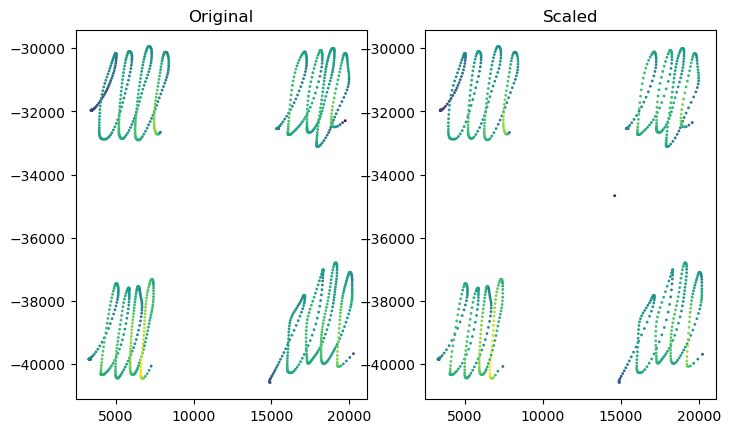

In [6]:
original_img = np.array(get_random_image(X, y, 0))
original_height, original_width = original_img.shape

new_shape = (original_img.shape[0] - 300, original_img.shape[1])

scaled_img = tf.image.resize(
    original_img.reshape((original_height, original_width, 1)),
    new_shape,
    method=tf.image.ResizeMethod.BILINEAR
)
scaled_img = tf.reshape(scaled_img, new_shape)

plt.close()
plt.figure(1)

plt.subplot(1, 2, 1)
plt.subplots_adjust(right=4)
plt.title('Original')
plt.scatter(original_img[:,1], original_img[:,2] * -1, c=original_img[:,3] + 1, s=1)

plt.subplot(1, 2, 2)
plt.subplots_adjust(left=4, right=5)
plt.title('Scaled')
plt.scatter(scaled_img[:,1], scaled_img[:,2] * -1, c=scaled_img[:,3] + 1, s=1)
plt.show()

In [19]:
from datamanipulation.extractors.main import *

X_extracted = extract_features(X, [MedianSmoothingExtractor(3, 400)])

In [20]:
i = 0
img_original = X[i]
img_extracted = X_extracted[i]

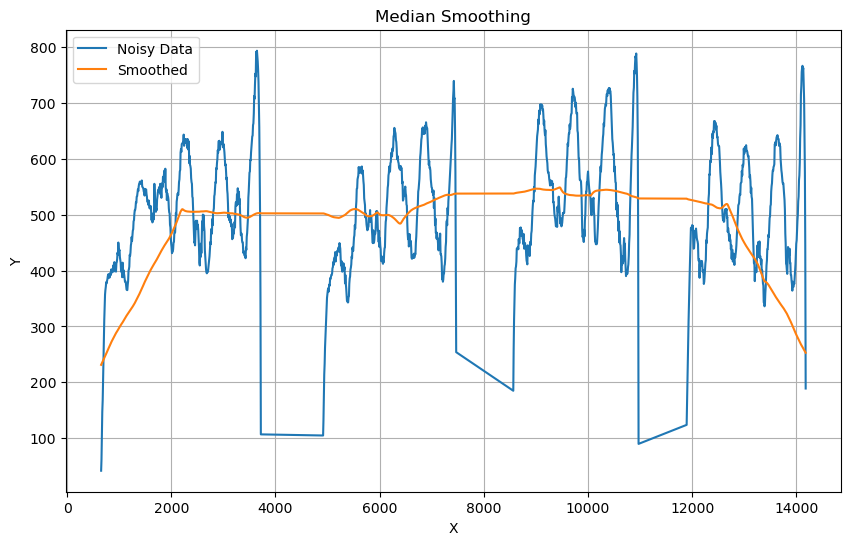

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0])

In [21]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(img_original[:,0], img_original[:,3], label='Noisy Data')
plt.plot(img_extracted[:,0], img_extracted[:,-1], label='Smoothed')
plt.legend()
plt.title('Median Smoothing')
plt.xlabel('X')
plt.ylabel('Y')
plt.grid(True)
plt.show()

y.reshape(-1, 1).reshape(-1)